In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("AmesHousing.csv")
data.info() # Checking summary of DataFrame for preprocessing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [3]:
data = data.drop(columns=["Pool QC","Fence","Alley","Misc Feature","Order","PID"]) # Dropping columns that have too many missing values or that are irrelevant for modeling

In [4]:
from sklearn.model_selection import train_test_split 

# Separate target column from the features (SalePrice)
X = data.drop(columns=['SalePrice']) 
y = data['SalePrice']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Rejoin y_train and y_test with their corresponding X_train and X_test to create train_data and test_data
train_data = X_train.join(y_train) 
test_data = X_test.join(y_test)

In [5]:
# Loop every categorical object type in training set to fill missing values. Looks first if a value occurs more than 100 times, it can use it to replace all the NaNs. 
# Otherwise, puts a "__MISSING__" 
for col in train_data.select_dtypes(include="object").columns: 
    mode_val = train_data[col].mode()[0] 
    train_data[col] = train_data[col].fillna(mode_val if train_data[col].value_counts()[mode_val] > 100 else "__MISSING__") 

In [6]:
# Fill missing numerical values by looping all columns where missing likely means "non" (e.g. no garage, no basement).
zeros_fill_cols = [
    'Garage Yr Blt', 'Garage Area', 'Garage Cars',
    'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
    'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath'
]
for col in zeros_fill_cols:
    train_data[col] = train_data[col].fillna(0)

# Missing values here are replaced with median
train_data['Lot Frontage'] = train_data['Lot Frontage'].fillna(train_data['Lot Frontage'].median())

<Axes: >

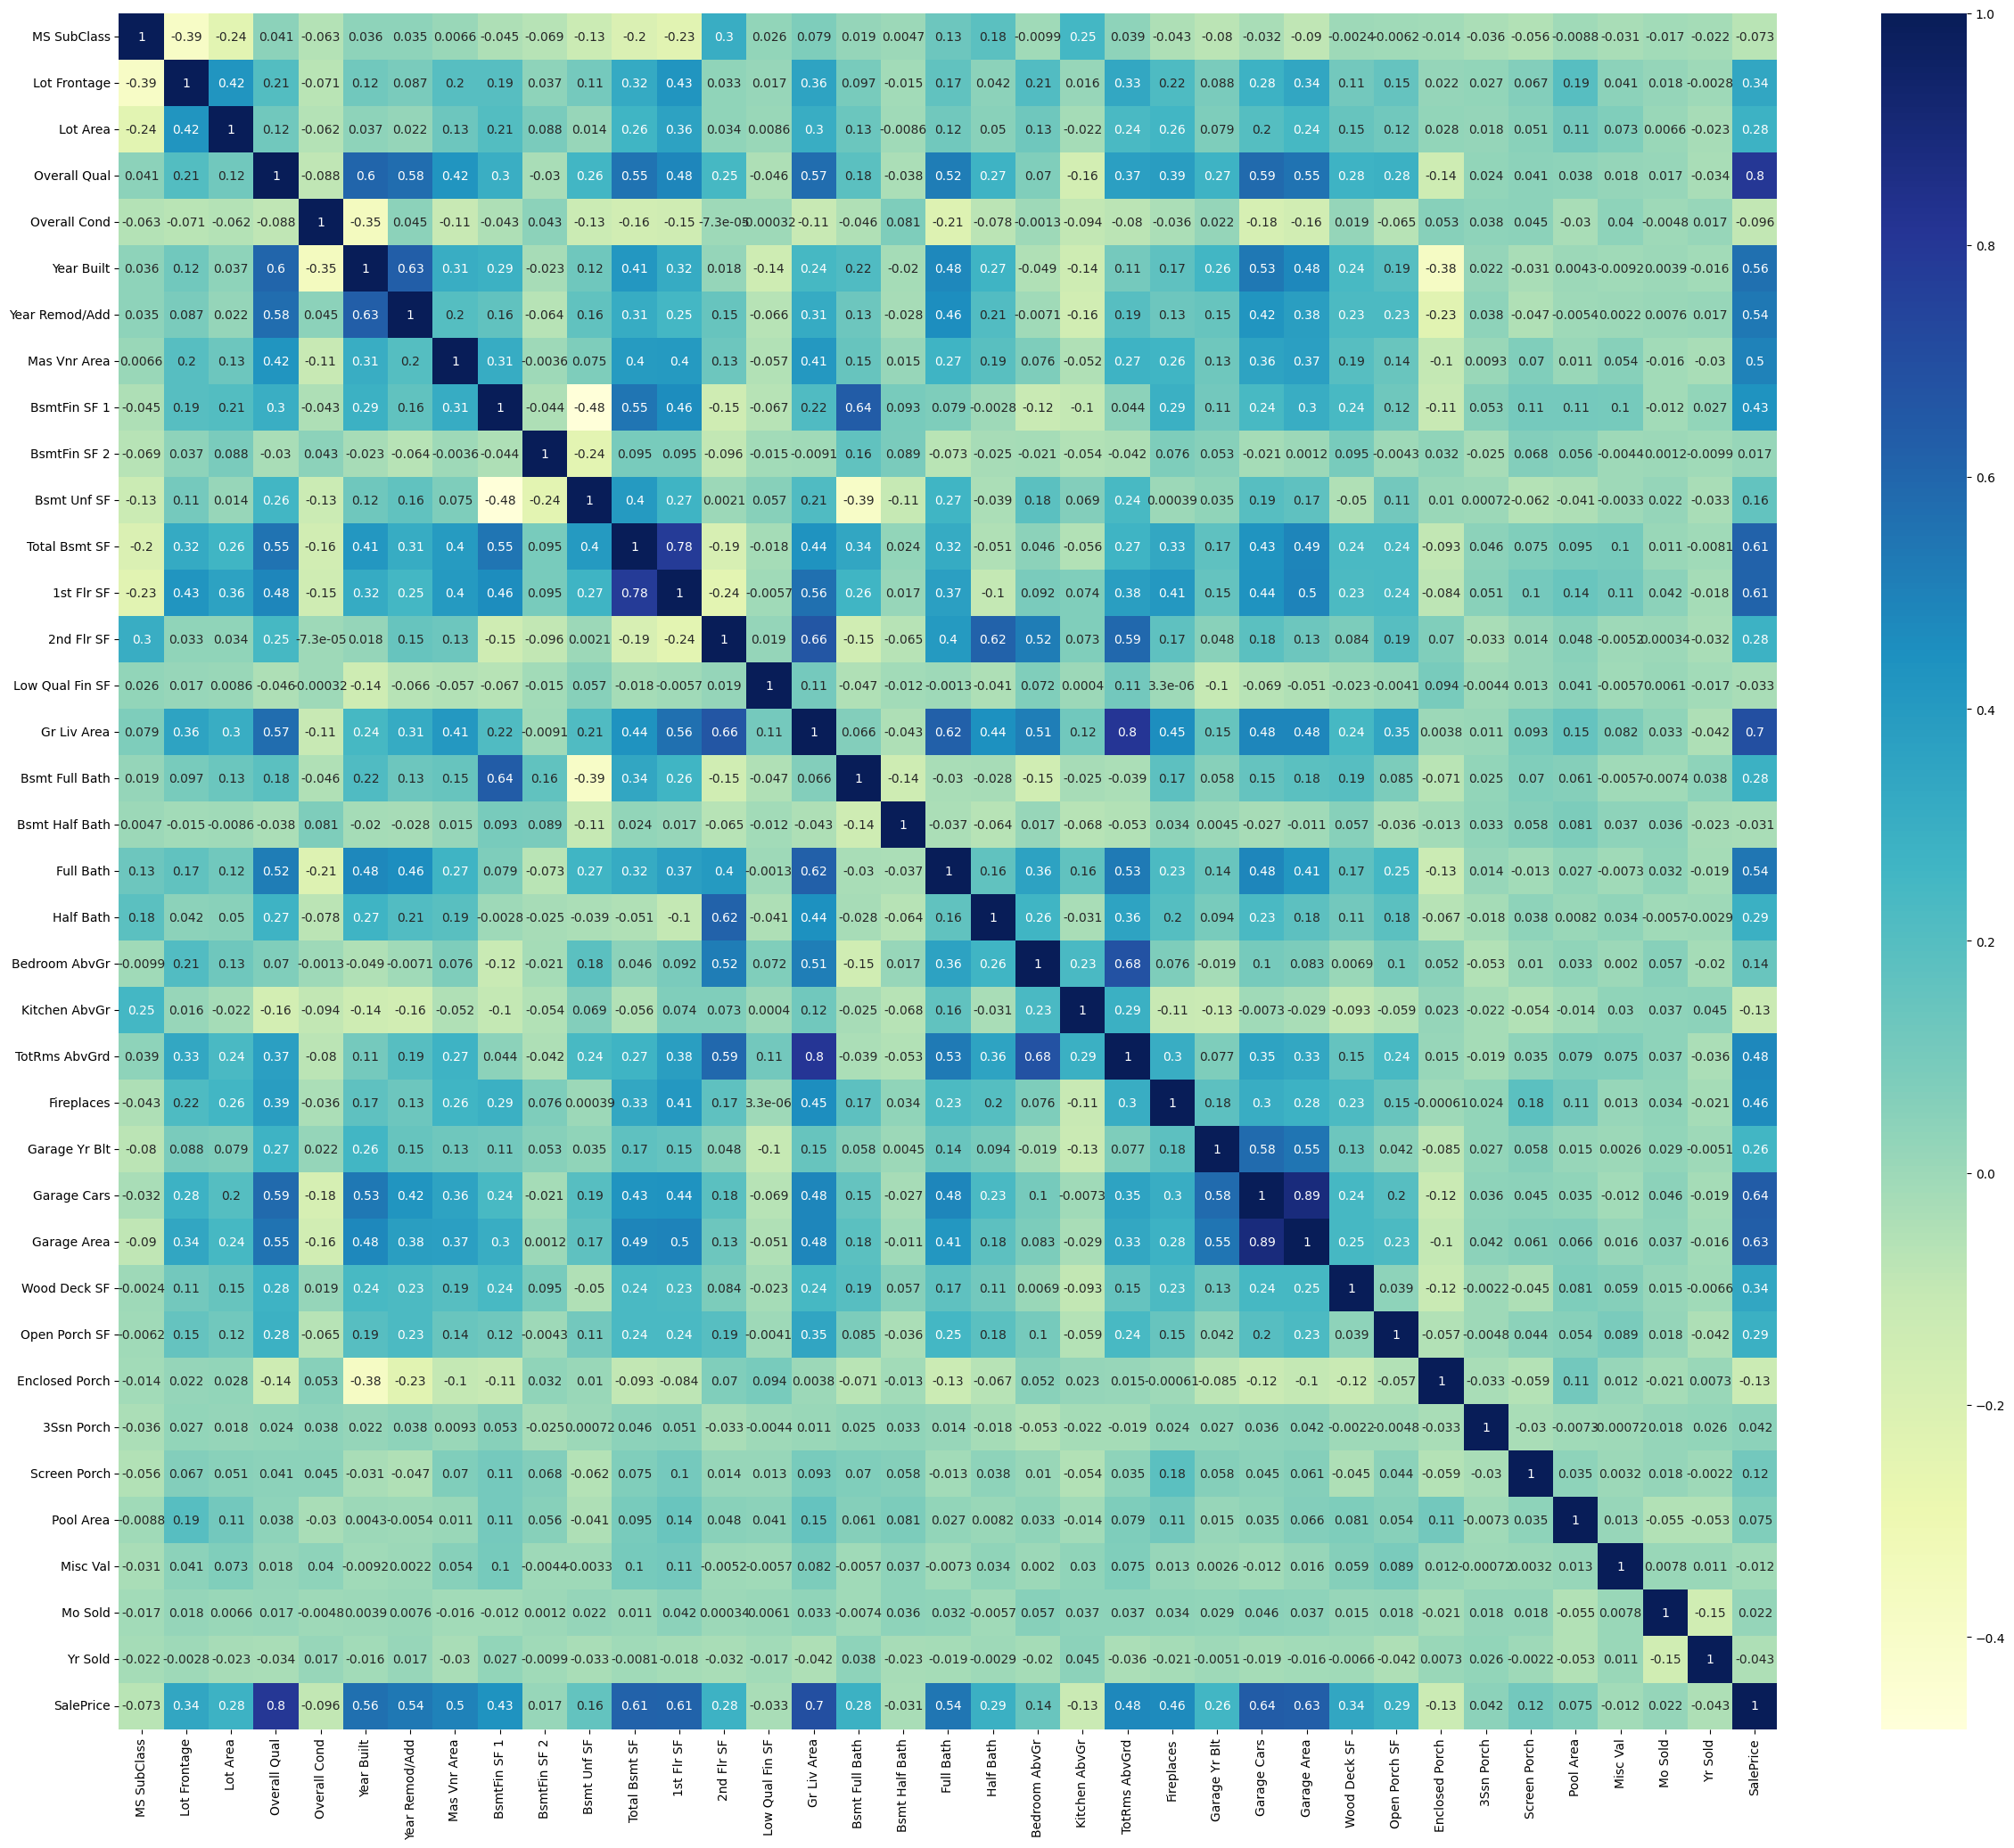

In [7]:
# Correlation with target variable
train_data.select_dtypes(include="number").corr() # Computes Pearson correlation between every pair of numerical columns. Values range from +1 (as one goes up, so does the other), 0 (no correlation), -1 (as one goes up, the other goes down).
# Heatmap
plt.figure(figsize=(30,25)) # rule of thumb: figsize = (num_columns * 1, num_columns * 0.5)
sns.heatmap(train_data.select_dtypes(include="number").corr(),annot=True, cmap="YlGnBu") # Heatmap, annot=True = aka we're going to see the correlation number

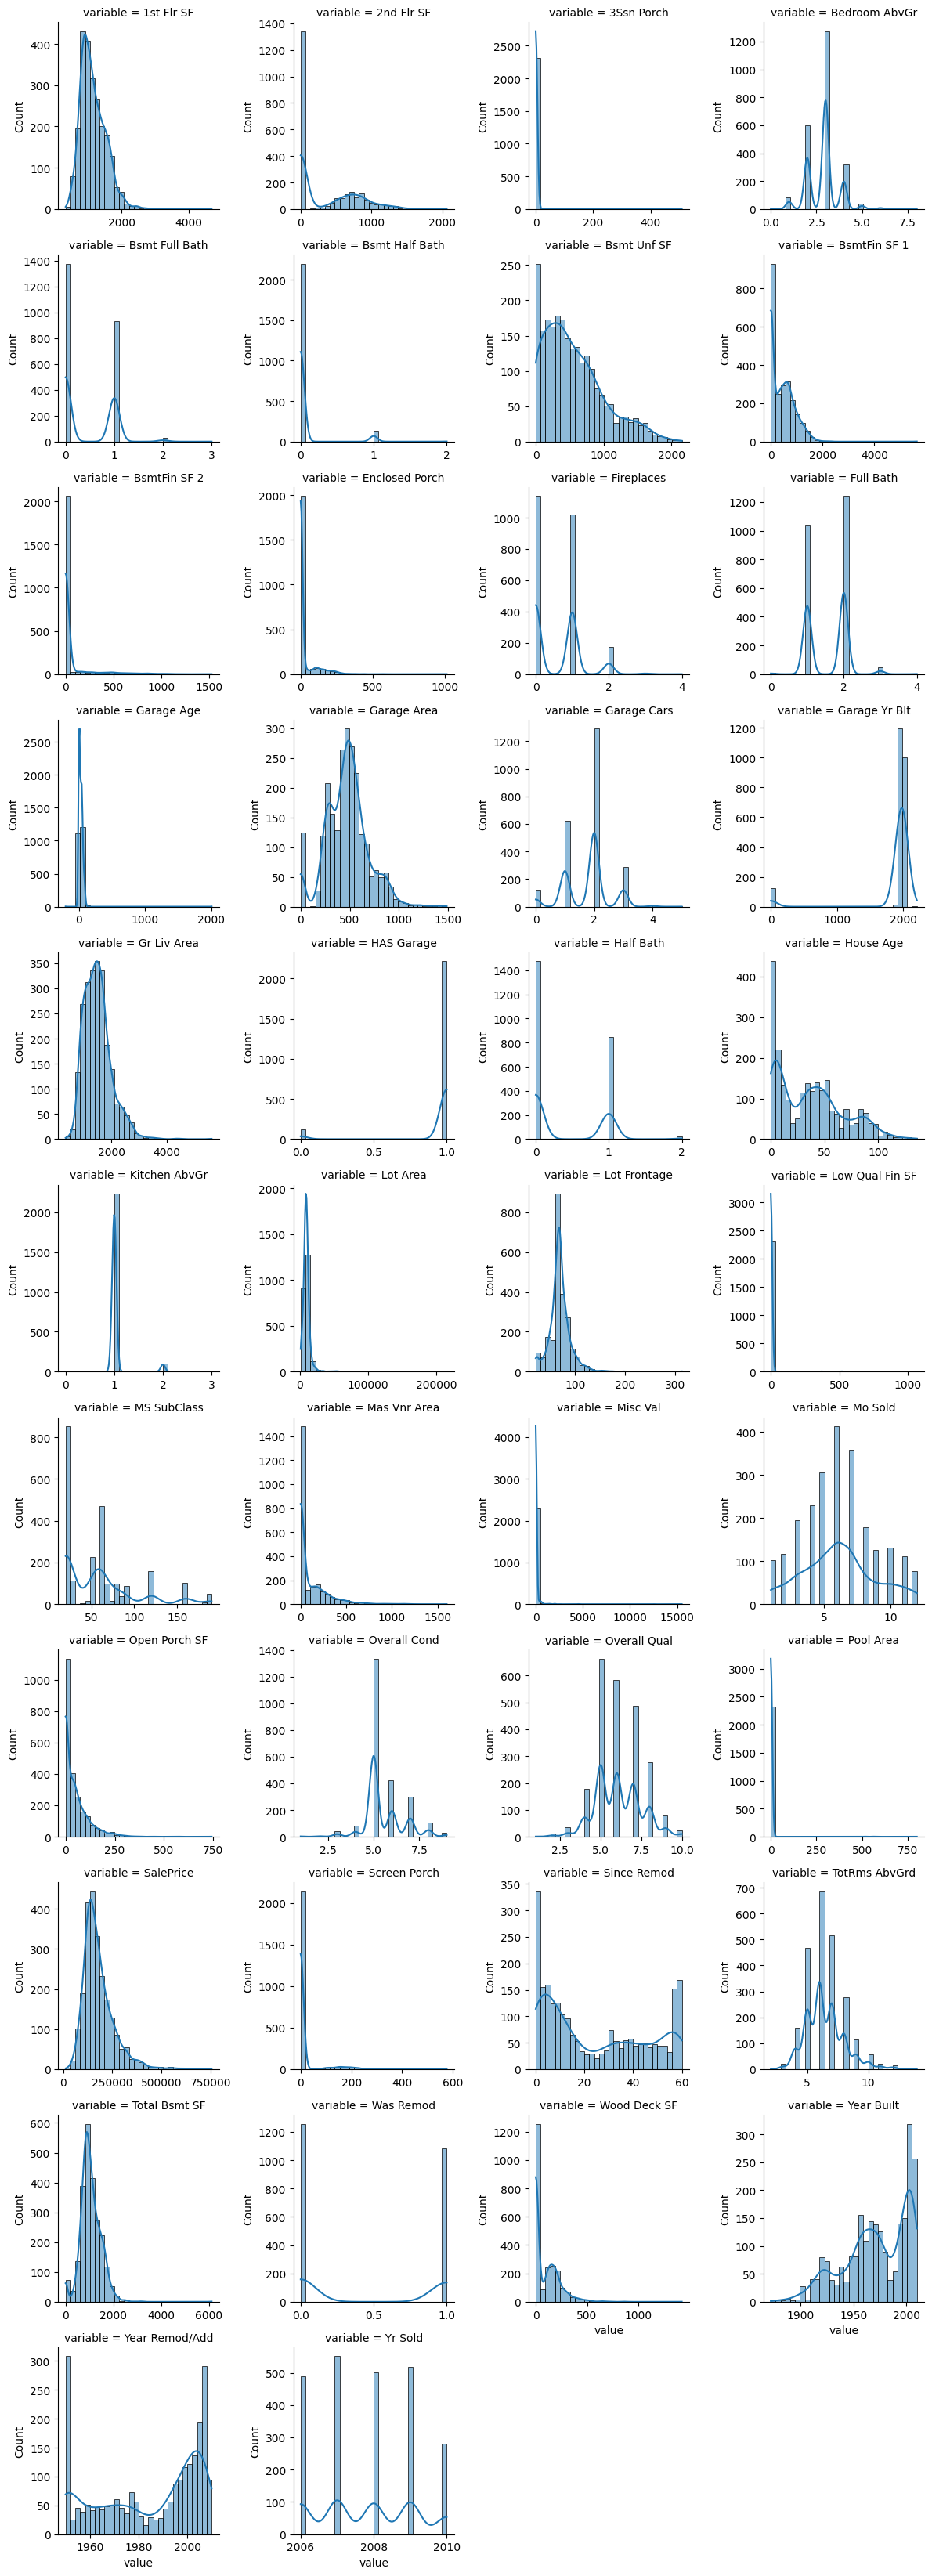

In [8]:
# === Age Features ===
train_data['House Age'] = train_data['Yr Sold'] - train_data['Year Built']
train_data['Since Remod'] = train_data['Yr Sold'] - train_data['Year Remod/Add'] # By doing this line, we see there's an error in hour dataset (house sold before it's built) so we drop that row
train_data = train_data[(train_data['House Age'] >= 0) & (train_data['Since Remod'] >= 0)].copy() # Dropping the rows where the house's age is under 0
train_data['Was Remod'] = (train_data['Year Built'] != train_data['Year Remod/Add']).astype(int)

# === Garage Features ===
train_data['HAS Garage'] = (train_data['Garage Area'] > 0).astype(int)
# First set Garage Yr Blt = NaN for houses with no garage
train_data.loc[train_data['HAS Garage'] == 0, 'Garage Yr Blt'] = np.nan
train_data['Garage Age'] = (train_data['Yr Sold'] - train_data['Garage Yr Blt']).fillna(-1)
train_data['Garage Yr Blt'] = train_data['Garage Yr Blt'].fillna(-1)

# BEFORE graphs
# 1. Grab all numerical columns from your train_data
num_features = train_data.select_dtypes(include='number').columns

# 2. Melt the dataframe to long format for FacetGrid
melted = pd.melt(train_data, value_vars=sorted(num_features))

# 3. Plot with FacetGrid and histplot
g = sns.FacetGrid(melted, col='variable', col_wrap=4, sharex=False, sharey=False, height=3)
g.map(sns.histplot, 'value', kde=True, bins=30)

plt.tight_layout()
plt.show()

In [9]:
# Calculate skewness of numeric features
skew_values = train_data.select_dtypes(include='number').skew()

# Sort by absolute skew (most skewed features first)
skew_sorted = skew_values.sort_values(ascending=False)

# Show top skewed features
print(skew_sorted)

Garage Age         29.160743
Misc Val           21.127158
Pool Area          15.769573
Lot Area           13.357063
Low Qual Fin SF    11.970554
3Ssn Porch         10.894000
Enclosed Porch      4.303824
Kitchen AbvGr       4.196864
Screen Porch        4.138158
BsmtFin SF 2        4.070884
Bsmt Half Bath      3.950706
Mas Vnr Area        2.637056
Open Porch SF       2.561441
Wood Deck SF        1.955443
Lot Frontage        1.860287
SalePrice           1.785291
BsmtFin SF 1        1.382048
MS SubClass         1.346657
1st Flr SF          1.205651
Gr Liv Area         1.172950
Total Bsmt SF       0.966096
Bsmt Unf SF         0.905522
2nd Flr SF          0.846631
Fireplaces          0.754359
TotRms AbvGrd       0.741371
Half Bath           0.716753
House Age           0.616051
Bsmt Full Bath      0.610123
Overall Cond        0.539643
Since Remod         0.433369
Garage Area         0.250347
Bedroom AbvGr       0.248722
Mo Sold             0.203991
Overall Qual        0.190803
Was Remod     

In [10]:
# === Log-Transform Skewed Numeric Features ===
log_cols = ['SalePrice', 'Lot Frontage', 'Lot Area', '1st Flr SF', 'Gr Liv Area', 'Total Bsmt SF']
for col in log_cols:
    train_data[col] = np.log(train_data[col] + 1)

# === Binary Flags for Presence of Features ===
binary_flags = {
    'Bsmt Unf SF': 'HAS Bsmt Unf',
    'Enclosed Porch': 'HAS Enclosed Porch',
    '3Ssn Porch': 'HAS 3Ssn Porch',
    'Screen Porch': 'HAS Screen Porch',
    'Open Porch SF': 'HAS Open Porch SF',
    'Wood Deck SF': 'HAS Wood Deck SF',
    'Pool Area': 'HAS Pool Area',
    'Misc Val': 'HAS Misc Val',
    'Mas Vnr Area': 'HAS Mas Vnr',
    'BsmtFin SF 1': 'HAS BsmtFin 1',
    'BsmtFin SF 2': 'HAS BsmtFin 2',
    '2nd Flr SF': 'HAS 2nd Flr',
    'Low Qual Fin SF': 'HAS Low Qual Fin',
    'Bsmt Full Bath': 'HAS Bsmt Full Bath',
    'Bsmt Half Bath': 'HAS Bsmt Half Bath'
}

for src_col, new_col in binary_flags.items():
    train_data[new_col] = (train_data[src_col] > 0).astype(int)

# === Fix MS SubClass as Categorical ===
train_data['MS SubClass'] = train_data['MS SubClass'].astype(str)

# === One-Hot Encoding Categorical columns ===
categorical_cols = train_data.select_dtypes(include = 'object').columns

train_data = pd.get_dummies(train_data, columns = categorical_cols, drop_first = True)

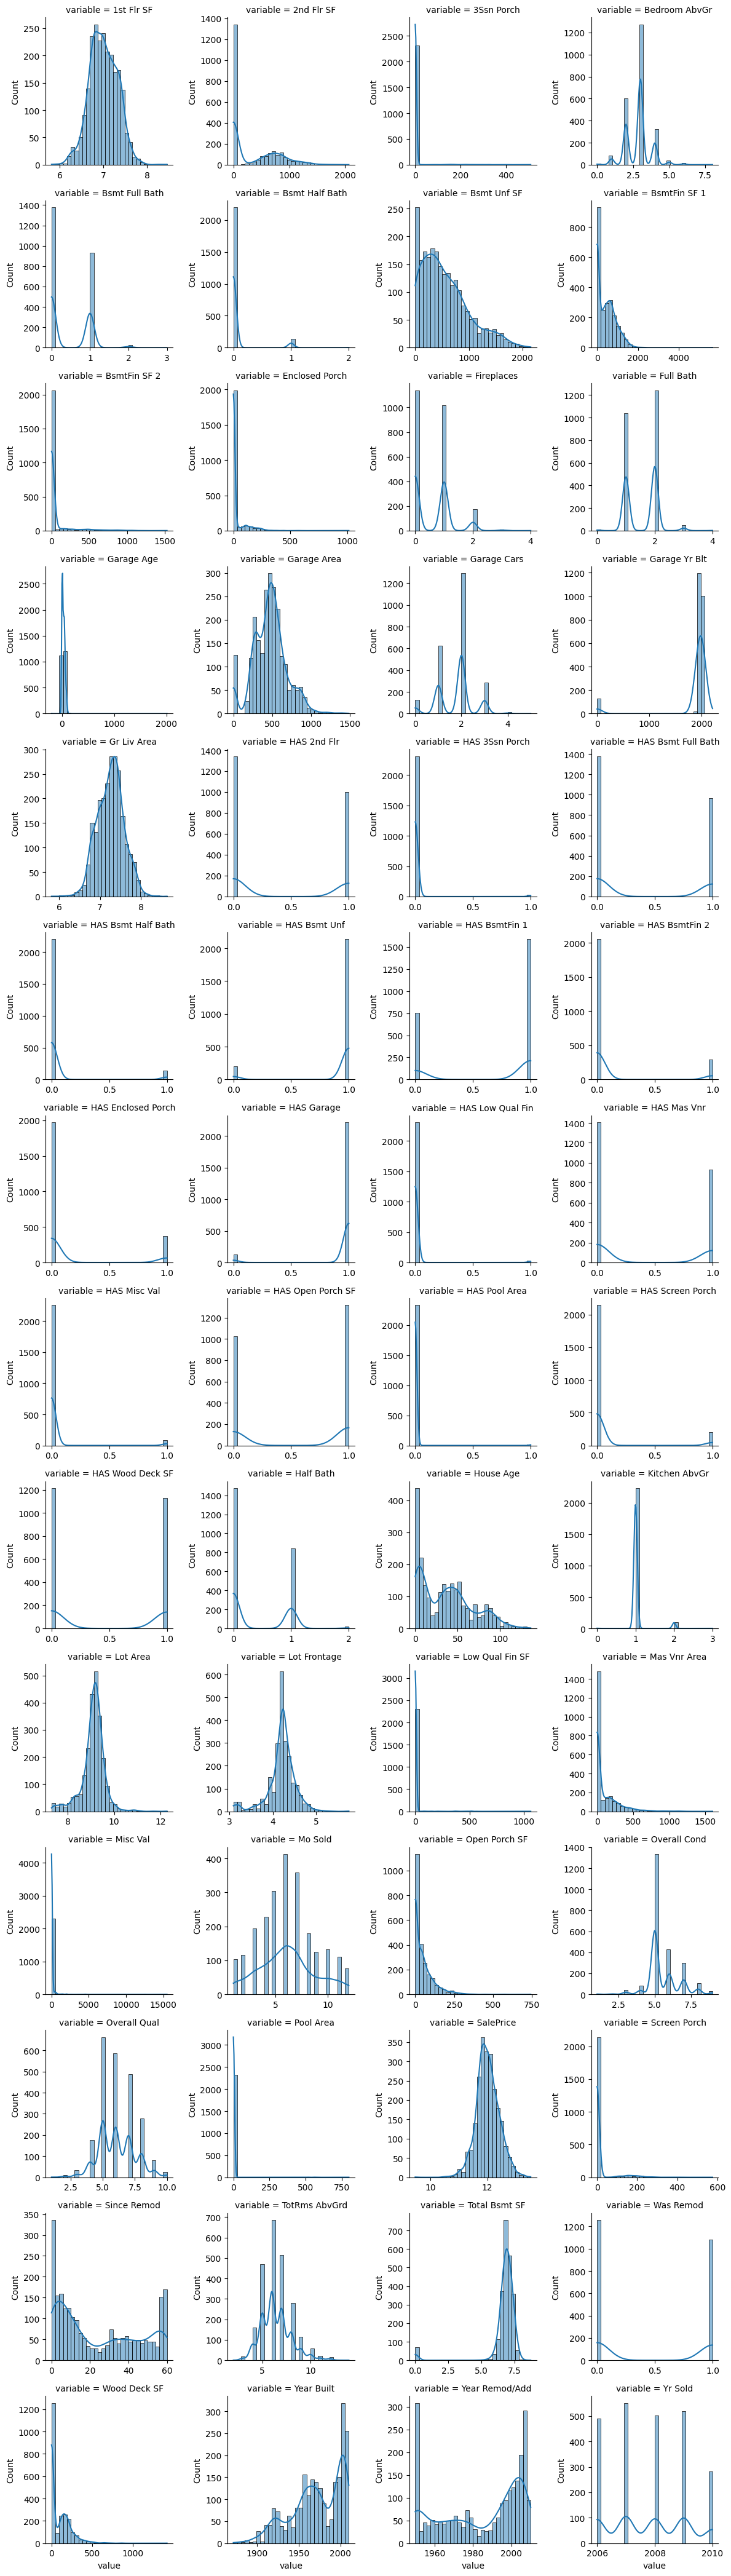

In [11]:
# BEFORE graph
# 1. Grab all numerical columns from your train_data
num_features = train_data.select_dtypes(include='number').columns

# 2. Melt the dataframe to long format for FacetGrid
melted = pd.melt(train_data, value_vars=sorted(num_features))

# 3. Plot with FacetGrid and histplot
g = sns.FacetGrid(melted, col='variable', col_wrap=4, sharex=False, sharey=False, height=3)
g.map(sns.histplot, 'value', kde=True, bins=30)

plt.tight_layout()
plt.show()

In [12]:
# Save fully preprocessed trained data
pd.set_option('display.max_columns', None)
train_data.head()
train_data.to_csv("preprocessed_data.csv", index=False)

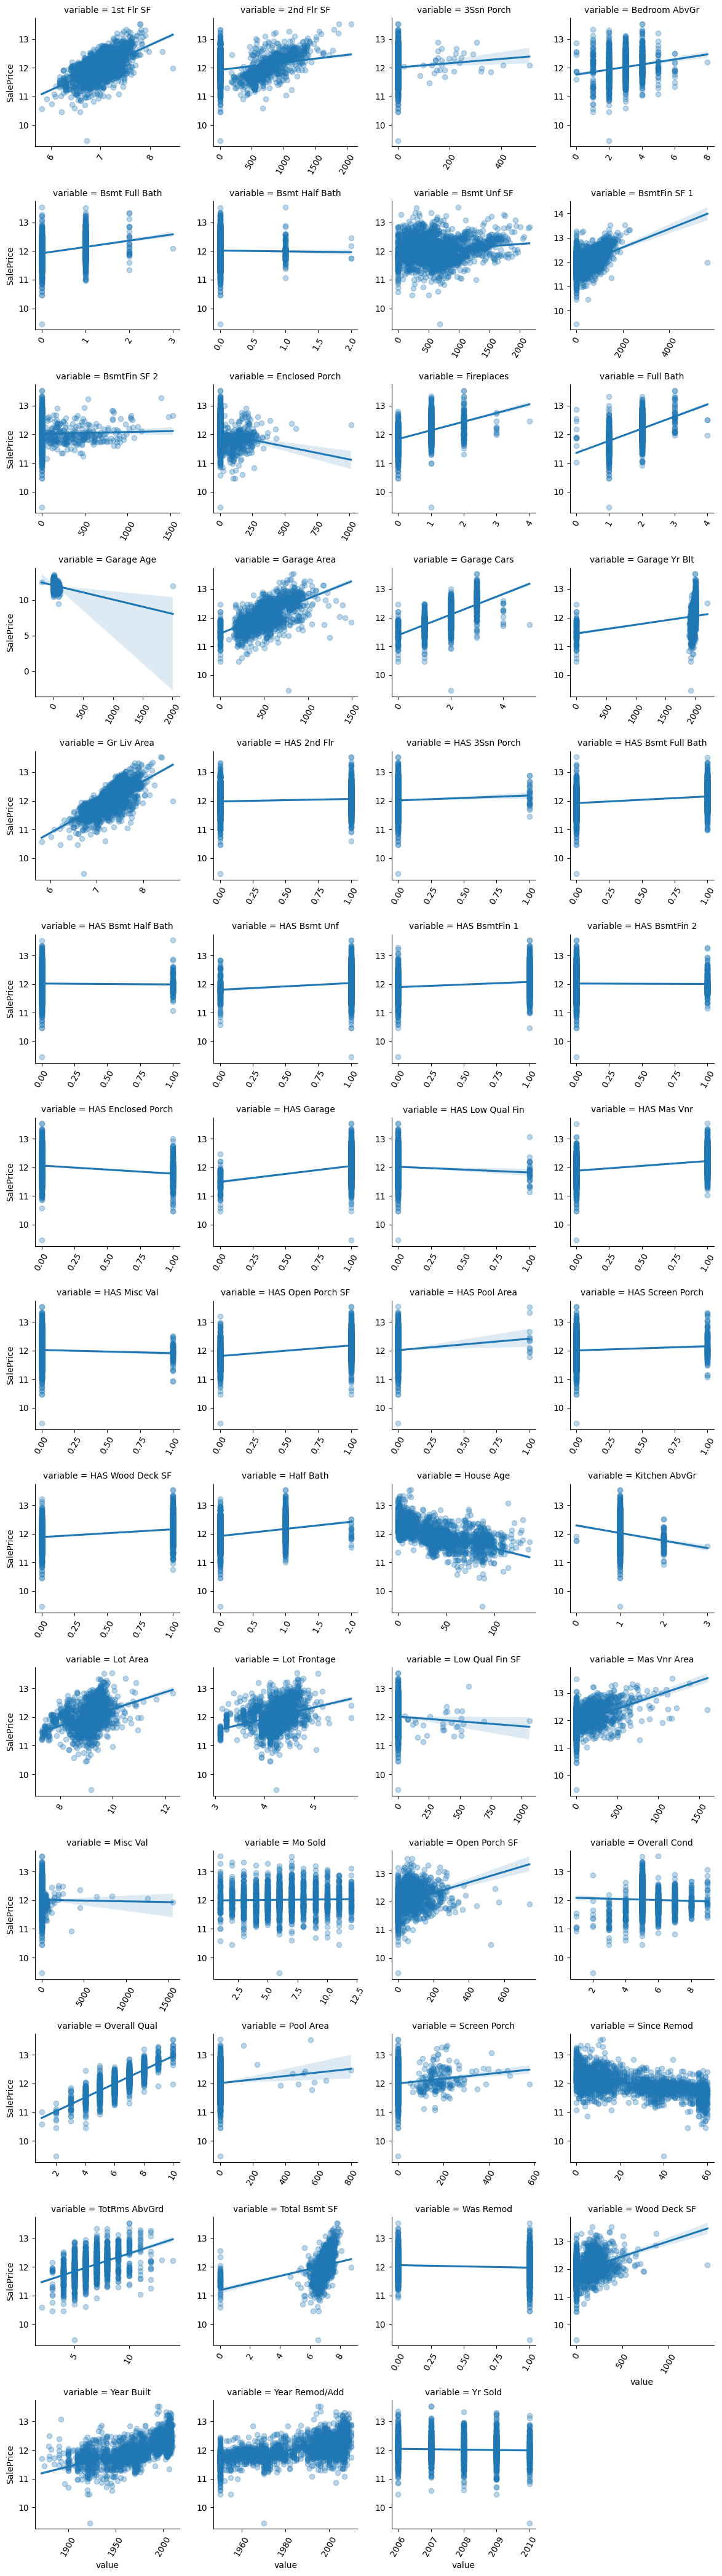

In [13]:
# Graph of how each feature correlates with SalePrice visually
f = pd.melt(train_data, id_vars=['SalePrice'], value_vars=sorted(num_features)) # Convert DataFram to long format
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False) # Set up a grid of plots
g = g.map(sns.regplot, 'value', 'SalePrice', scatter_kws={'alpha':0.3}) 
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat] 
g.fig.tight_layout()
plt.show()

In [14]:
# We do the same transformation as we did with train_data but with the test_data
# We're going to prepare a pipeline instead this time
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

# Loop every categorical object type to fill missing values
class CustomCategoricalImputer(BaseEstimator, TransformerMixin):       
    def fit(self, X, y=None):
        self.fill_values_ = {}
        for col in X.select_dtypes(include="object").columns:
            mode_val = X[col].mode(dropna=True)[0]
            count = X[col].value_counts().get(mode_val, 0)
            if count > 100:
                self.fill_values_[col] = mode_val
            else:
                self.fill_values_[col] = "__MISSING__"
        return self
        
    def transform(self, X):
        X_ = X.copy()
        for col, val in self.fill_values_.items():
            X_[col] = X_[col].fillna(val)
        return X_
                
# Fill missing numerical values
class ZeroImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cols = [
            'Garage Yr Blt', 'Garage Area', 'Garage Cars',
            'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
            'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath'
        ]
        self.imputer = SimpleImputer(strategy="constant", fill_value=0)

    def fit(self, X, y=None):
        self.imputer.fit(X[self.cols])
        return self

    def transform(self, X):
        X_ = X.copy()
        X_[self.cols] = self.imputer.transform(X_[self.cols])
        return X_

# Separate for Lot frontage (estimate), random missing size
class LotFrontageMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy="median")
        self.col = 'Lot Frontage'

    def fit(self, X, y=None):
        self.imputer.fit(X[[self.col]])
        return self

    def transform(self, X):
        X_ = X.copy()
        X_[[self.col]] = self.imputer.transform(X_[[self.col]])
        return X_

# === House Age ===
class AgeFeature_House(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        X_['House Age'] = X_['Yr Sold'] - X_['Year Built']
        X_['Since Remod'] = X_['Yr Sold'] - X_['Year Remod/Add']
        X_ = X_[(X_['House Age'] >= 0) & (X_['Since Remod'] >= 0)]
        X_['Was Remod'] = (X_['Year Built'] != X_['Year Remod/Add']).astype(int)
        return X_

# === Garage Features ===
class AgeFeature_Garage(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        X_['HAS Garage'] = (X_['Garage Area'] > 0).astype(int)
        X_.loc[X_['HAS Garage'] == 0, 'Garage Yr Blt'] = np.nan
        X_['Garage Age'] = (X_['Yr Sold'] - X_['Garage Yr Blt']).fillna(-1)
        X_['Garage Yr Blt'] = X_['Garage Yr Blt'].fillna(-1)
        return X_

# === Log-Transform Skewed Numeric Features ===
log_cols = ['SalePrice', 'Lot Frontage', 'Lot Area', '1st Flr SF', 'Gr Liv Area', 'Total Bsmt SF']
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self  # nothing to learn

    def transform(self, X):
        X_ = X.copy()
        for col in self.columns:
            X_[col] = np.log1p(X_[col])  # log(1 + x)
        return X_

# === Binary Flags for Presence of Features ===
class BinaryFlagGenerator(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.flags = {
            'Bsmt Unf SF': 'HAS Bsmt Unf',
            'Enclosed Porch': 'HAS Enclosed Porch',
            '3Ssn Porch': 'HAS 3Ssn Porch',
            'Screen Porch': 'HAS Screen Porch',
            'Open Porch SF': 'HAS Open Porch SF',
            'Wood Deck SF': 'HAS Wood Deck SF',
            'Pool Area': 'HAS Pool Area',
            'Misc Val': 'HAS Misc Val',
            'Mas Vnr Area': 'HAS Mas Vnr',
            'BsmtFin SF 1': 'HAS BsmtFin 1',
            'BsmtFin SF 2': 'HAS BsmtFin 2',
            '2nd Flr SF': 'HAS 2nd Flr',
            'Low Qual Fin SF': 'HAS Low Qual Fin',
            'Bsmt Full Bath': 'HAS Bsmt Full Bath',
            'Bsmt Half Bath': 'HAS Bsmt Half Bath'
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        for src_col, new_col in self.flags.items():
            X_[new_col] = (X_[src_col] > 0).astype(int)
        return X_

# === Fix MS SubClass as Categorical ===
class SubclassCast(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self  # nothing to learn

    def transform(self, X):
        X_ = X.copy()
        X_[self.column] = X_[self.column].astype(str)  
        return X_

# === One-Hot Encoding Categorical columns ===
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.categorical_cols_ = X.select_dtypes(include='object').columns
        self.dummies_columns_ = pd.get_dummies(X, columns=self.categorical_cols_, drop_first=True).columns
        return self

    def transform(self, X):
        X_ = pd.get_dummies(X, columns=self.categorical_cols_, drop_first=True)
        
        missing_cols = [col for col in self.dummies_columns_ if col not in X_.columns]
        for col in missing_cols:
            X_[col] = 0  
        return X_[self.dummies_columns_]  

# === Pipeline ===
full_pipeline = Pipeline([
    ('impute_cat', CustomCategoricalImputer()),
    ('zero_imputer', ZeroImputer()),
    ('lot_frontage_imputer', LotFrontageMedianImputer()),
    ('age_features_house', AgeFeature_House()),
    ('age_features_garage', AgeFeature_Garage()),
    ('log_transform', LogTransformer(log_cols)),
    ('binary_flags', BinaryFlagGenerator()),
    ('cast_ms_subclass', SubclassCast('MS SubClass')),
    ('custom_hotencoder', CustomOneHotEncoder())
])

# Apply pipeline
test_data = full_pipeline.fit_transform(test_data)

In [15]:
# Since pd.get_dummies() only creates columns for categories that actually appear, if a category is missing in the test data, we could have less columns
if test_data.shape[1] != train_data.shape[1]:
    test_data = test_data.reindex(columns=train_data.columns, fill_value=0)

In [16]:
X_train = train_data.drop(columns='SalePrice')
y_train = train_data['SalePrice']

X_test = test_data.drop(columns='SalePrice')
y_test = test_data['SalePrice']

Sample y_test values: 1236    11.849405
1021    12.301387
490     12.409018
95      11.951187
177     11.775297
Name: SalePrice, dtype: float64
RMSE: 0.1325175448528452
R²: 0.8996779680753028


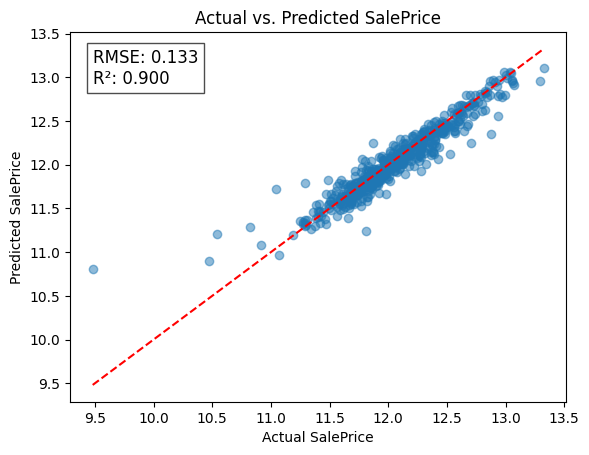

In [17]:
from xgboost import XGBRegressor
import warnings
from xgboost.callback import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score

# Suppress the specific UserWarning from xgboost regarding callbacks in fit
warnings.filterwarnings(
    "ignore",
    message="`callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.",
    category=UserWarning,
    module="xgboost" # Specify the module to be more precise
)

# 1. Train the model
lr_model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    reg_alpha=0.1,
    reg_lambda=1.0,
    learning_rate=0.03,
    random_state=42
) # creates an empty XGBRegressor model, not trained

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    rounds=20,  # Stop if no improvement for 20 rounds
    min_delta=0.001,  # Minimum change to qualify as improvement
    data_name="validation_0", # Name of the validation set in eval_set
    metric_name="rmse",       # Metric to monitor for early stopping
    maximize=False,           # For RMSE, we want to minimize (False)
    save_best=True,           # Save the best model state
    
)

lr_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[early_stopping_callback], # Use the callbacks argument
    verbose=False
) # we train the model using training data (X_train and y_train) (model learns the pattern and tries to find the best line that fits the data
lr_model.score(X_test, y_test)

# 2. Predict
y_pred = lr_model.predict(X_test) # use the trained model to make predicitons on the new data (X_test) to get an estimate of what the y values should be

# 3. Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # we compare the model's predicitons (y_pred) with the actual values (y_test) to calculate the Root Mean Squared Error (RMSE) the smaller it is the better 
r2 = r2_score(y_test, y_pred)

print("Sample y_test values:", y_test.head()) #added
print("RMSE:", rmse)
print("R²:", r2)

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs. Predicted SalePrice")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # perfect prediction line

# Add RMSE and R² to plot
plt.text(
    x=y_test.min(), 
    y=y_test.max(), 
    s=f"RMSE: {rmse:.3f}\nR²: {r2:.3f}",
    fontsize=12,
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.7)
)

plt.show()

In [18]:
# Checking if overfitting:
# Predictions
train_pred = lr_model.predict(X_train)
test_pred = lr_model.predict(X_test)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print("TRAIN RMSE:", train_rmse)
print("TEST RMSE:", test_rmse)
print("TRAIN R²:", train_r2)
print("TEST R²:", test_r2)

TRAIN RMSE: 0.06152297699274689
TEST RMSE: 0.1325175448528452
TRAIN R²: 0.9768956697380087
TEST R²: 0.8996779680753028


Garage Finish_Unf       0.233495
Garage Cars             0.080370
Fireplaces              0.075093
Overall Qual            0.060964
Gr Liv Area             0.041177
Total Bsmt SF           0.039056
House Age               0.038421
Central Air_Y           0.025711
MS Zoning_RL            0.025358
Paved Drive_Y           0.025306
Year Remod/Add          0.018609
MS SubClass_60          0.016642
MS Zoning_RM            0.013915
BsmtFin SF 1            0.013269
Kitchen Qual_TA         0.012080
MS SubClass_30          0.007813
Bsmt Exposure_Gd        0.007274
Garage Yr Blt           0.007174
Exterior 2nd_BrkFace    0.006516
Since Remod             0.006268
dtype: float32


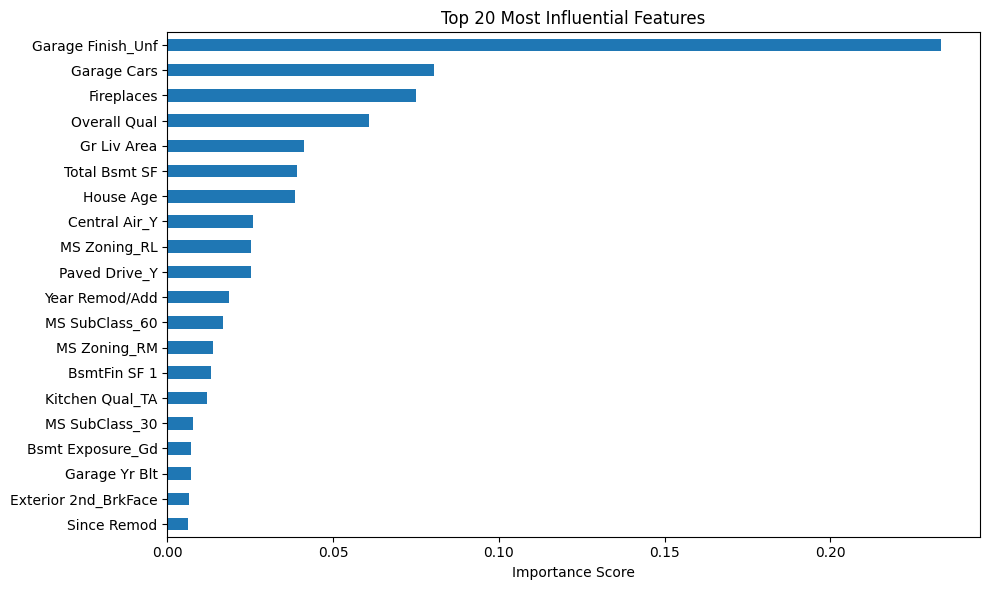

In [19]:
# We rank the top 20 features the model thinks are the most useful for predicting SalePrice
feature_importance = pd.Series(lr_model.feature_importances_, index=lr_model.feature_names_in_)
top_20 = feature_importance.sort_values(ascending=False).head(20)
print(top_20)

top_20.plot(kind="barh", figsize=(10,6))
plt.gca().invert_yaxis()  # Show most important at top
plt.title("Top 20 Most Influential Features")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [20]:
import joblib

# Save model
joblib.dump(lr_model, "XGBRegressor_model.pkl")

# Save the list of columns the model expects
joblib.dump(X_train.columns.tolist(), "model_features.pkl")

['model_features.pkl']